In [386]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from scipy.optimize import curve_fit 
import scipy.integrate as integrate
import scipy.special as special
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D







from collections import OrderedDict


In [387]:
tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
#absorp_tab = Table.read('../3D_CMZ/LBV_plots_stuff/absorption_table_merged.tex')
starcount_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex")


cat_index = tab['leaf_id']
cloud_name = tab['cloud_name']
corr_coeff = tab['corr_coeff']
flux_diff = tab['flux_diff']
fdiff_stdv = tab['flux_diff_stdv']
flux_ratio = tab['flux_ratio']
fratio_stdv = tab['flux_ratio_stdv']
absorp_value = tab['absorp_value']
starcount_ratio = starcount_tab['counts_ratio_from_avg']
starcount_ratio_stdv = starcount_tab['counts_ratio_stdv']


In [388]:
starcount_tab[9]

cloud_index,cloud_name,cloud_avg_count,model_avg_count,cloud_min_count,model_min_count,counts_ratio_from_avg,counts_ratio_stdv
str3,str14,float64,float64,float64,float64,float64,float64
7b,G359.701+0.032,54.37656508329836,59.48042160797076,53.963549497450764,57.51892601089832,0.9153301716789798,0.015140857889002199


In [389]:
tab[13]

leaf_id,cloud_name,l,b,v,sigma,rad,corr_coeff,flux_diff,flux_diff_stdv,flux_ratio,flux_ratio_stdv,absorp_value,NF_decision,absorp_NF,lb_pixel_mask
str3,str14,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str3,str3,int64
9,G359.88-0.081,-0.12,-0.081,15,12,5.0,0.6,-5.06,54.9,0.31,0.13,3.45,LN,N,1


In [535]:
def z_norming(i, min_value, max_value):
    z_i = 2. * ((i - min_value) / (max_value - min_value)) - 1.
    return z_i

def stdv_z_norming(i, min_value, max_value):
    z_i =  ((i - min_value) / (max_value - min_value)) 
    return z_i

# normalize the data value between -1 and 1 for the 
# flux difference list 
# but need to center it on -108
#fdiff_cn = z_norming(-108, np.nanmin(flux_diff), np.nanmax(flux_diff))
fdiff_cn = z_norming(-108, -150, 150)

fdiff_stdv_centered = fdiff_stdv 

# flux ratio is centered on 0.5
#fratio_cn = z_norming(0.5, np.nanmin(flux_ratio), np.nanmax(flux_ratio))
fratio_cn = z_norming(0.5, 0., 1.)
fratio_stdv_centered = (fratio_stdv)

# Absorption centered on 1.
absorp_cn = z_norming(1., np.nanmin(absorp_value), 3.5)


# Star Count ratio centered on 1, min 0 and max 2
countratio_cn = z_norming(1., 0, 2)
##for star count stdv, mask out the stdv of the central SgrA* cloud
# since the central area of the model is not as well fit/trusted in the fitting
starcount_stdv_filter = np.copy(starcount_ratio_stdv)
ignore_ratiostdv = ['9', '10', '8','11', '12', '15', '13','14','16']
for i in range(len(starcount_stdv_filter)):
    if cat_index[i] not in ignore_ratiostdv:
        starcount_stdv_filter[i]=np.nan




flux_ratio_normed = []
flux_diff_normed = []
fdiff_stdv_normed = []
fratio_stdv_normed = []
absorp_normed = []
starcounts_normed = []
starcounts_stdv_normed = []
counts_ratio_stdv_calc = []

for i in range(len(cat_index)):
    
    ###FDIFF NORMING 
    z_fdiff_i = z_norming(flux_diff[i], np.nanmin(flux_diff), np.nanmax(flux_diff))
    flux_diff_normed.append(z_fdiff_i-fdiff_cn) 
    
    z_fdiff_stdv_i = stdv_z_norming(fdiff_stdv_centered[i], np.nanmin(flux_diff), np.nanmax(flux_diff))
    fdiff_stdv_normed.append(z_fdiff_stdv_i)
    
    ###FRATIO NORMING 
    z_i = z_norming(flux_ratio[i], 0, 1)
    flux_ratio_normed.append(-(z_i-fratio_cn)) 
    
    z_fratio_stdv_i = z_norming(fratio_stdv_centered[i], np.nanmin(flux_ratio), np.nanmax(flux_ratio))
    #z_fratio_stdv_i = stdv_z_norming(fratio_stdv_centered[i], 0, 1)
    fratio_stdv_normed.append(np.abs((z_fratio_stdv_i)))
    
    ###ABSORP NORMING 
    if np.isnan(absorp_value[i]) == False:
        z_i_absorp = z_norming(absorp_value[i], np.nanmin(absorp_value), 3.5)
        absorp_normed.append(-(z_i_absorp-absorp_cn))
    if np.isnan(absorp_value[i]) == True:
        absorp_normed.append(np.nan)
        
    ###STARCOUNTS NORMING
    z_countratio_i = z_norming(starcount_ratio[i], 0, 2)
    starcounts_normed.append(-(z_countratio_i-countratio_cn) )
    
    #z_countratio_stdv_i =  stdv_z_norming(starcount_stdv_filter[i], np.nanmin(starcount_stdv_filter), np.nanmax(starcount_stdv_filter))
    
    z_countratio_stdv_i =  stdv_z_norming(starcount_stdv_filter[i], 0,2)
    counts_ratio_stdv_calc.append(z_countratio_stdv_i)
    
starcounts_stdv_normed = np.full(len(counts_ratio_stdv_calc), np.nanmax(counts_ratio_stdv_calc))
fratio_stdv_normed = np.full(len(fratio_stdv_normed),np.nanmean(fratio_stdv_normed)) #flux ratio is also fairly susceptible to uncertainty in the central region

In [537]:
def corr_coeff_gauss_dist(x, mu):
    if np.isnan(mu)==True:
        return x*np.nan

    if (mu < 0) or (mu > 0.3):
        sigma = np.nanstd(corr_coeff)
    if (mu < 0.3) & (mu >= 0):
        sigma = np.nanstd(3.*corr_coeff)
    
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return   exp 


def flux_diff_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)
    #factor = 1./( sigma * np.sqrt(2.*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
    return    exp 



def flux_ratio_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)  
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return      exp 


def absorp_gauss_dist(x, mu):
    sigma = np.nanstd(absorp_normed, where=np.array(absorp_value)<3.5)     
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return     exp 

def starcount_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)  
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return      exp 


def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

In [546]:
x = np.arange(-20,20, 0.01)


class ppdf:
        
    def __init__(self, cloud_id):
        x = np.arange(-20,20, 0.01)

        cat_id = np.where(cat_index == cloud_id)[0][0]

        if np.isnan(corr_coeff[cat_id])==False:
            r_dist = corr_coeff_gauss_dist(x, corr_coeff[cat_id]) 
            r_norm = integrate.quad(corr_coeff_gauss_dist, -np.inf, np.inf, args=(corr_coeff[cat_id]))[0]
            r_dist      /=  r_norm 
            self.corr_coeff = r_dist 

        if np.isnan(absorp_normed[cat_id])==False:
            absorp_dist = absorp_gauss_dist(x, absorp_normed[cat_id])
            absorp_norm = integrate.quad(absorp_gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id]))[0]
            absorp_dist /=  absorp_norm
            self.absorp = absorp_dist 


        fratio_dist = flux_ratio_gauss_dist(x, flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id])
        fratio_norm = integrate.quad(flux_ratio_gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
        fratio_dist /=  fratio_norm 
        self.fratio = fratio_dist


        fdiff_dist = flux_diff_gauss_dist(x, flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id] )    
        fdiff_norm = integrate.quad(flux_diff_gauss_dist, -np.inf,np.inf, args=(flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id]))[0]
        fdiff_dist  /=  fdiff_norm
        self.fdiff = fdiff_dist

        starcount_dist = starcount_gauss_dist(x, starcounts_normed[cat_id],starcounts_stdv_normed[cat_id] )    
        starcount_norm = integrate.quad(starcount_gauss_dist, -np.inf,np.inf, args=(starcounts_normed[cat_id],starcounts_stdv_normed[cat_id]))[0]
        starcount_dist  /=  starcount_norm
        self.starcount = starcount_dist

        ### Calculate the posterior PDF
        
        total_pdf = np.empty(np.shape(x))
        total_pdf[:] = 1.
        
        self_dict = vars(self)
        
        uniform_pdf = np.ones(np.shape(x))
        
        ### Assign weights to the distributions
        ### Gaussians are best weighted by the means 
        ### other PDF shapes may be better weighted by amplitude
        for i in self_dict.items():
            #total_pdf *= i[1]
        

            if i[0]=='corr_coeff'  :     
                w = weights(i[0])
                i_weighted = i[1]*(w) + uniform_pdf*(1- w)  / np.sum(i[1])
            if i[0]=='absorp'      :     
                w =  weights(i[0])
                i_weighted = i[1]*(w) + uniform_pdf*(1- w) / np.sum(i[1])
            if i[0]=='fratio'      :     
                w =  weights(i[0])
                i_weighted = i[1]*(w) + uniform_pdf*(1- w) / np.sum(i[1])
            if i[0]=='fdiff'       :     
                w =  weights(i[0])
                i_weighted = i[1]*(w) + uniform_pdf*(1- w) / np.sum(i[1])
            if i[0]=='starcount'   :     
                w =  weights(i[0])
                i_weighted = i[1]*(w) + uniform_pdf*(1- w) / np.sum(i[1])
            
            total_pdf *= i_weighted
            total_norm  = integrate.trapezoid(total_pdf, x)
            total_pdf /= total_norm
        total_pdf/=total_pdf.max()
        
        self.posterior = total_pdf
        
        

                
        

def plotting_color_label(key):
    if key == 'corr_coeff': return 'blue'
    if key == 'absorp': return 'red'
    if key == 'fratio': return 'green'
    if key == 'fdiff': return 'orange'
    if key == 'starcount': return 'gold'
    if key == 'posterior': return 'black'

def plotting_linestyles(key):
    if key == 'corr_coeff': return '--'
    if key == 'absorp': return '-'
    if key == 'fratio': return '-.'
    if key == 'fdiff': return '--'
    if key == 'starcount': return '--'
    if key == 'posterior': return '-'
    
    
def weights(key):
    if key == 'corr_coeff': return 1./3.
    if key == 'absorp': return 1./3.
    if key == 'fratio': return 1./9.
    if key == 'fdiff': return 1./9.
    if key == 'starcount': return 1./9.
    if key == 'posterior': return 1.
    

def plot_pdf(cloud_id, pdfvar):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]
    
    ###Plot the stuff 
    fig, ax = plt.subplots(1, 1)
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(i[0]), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )



    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    ax.legend(loc=2)
        
    return
    

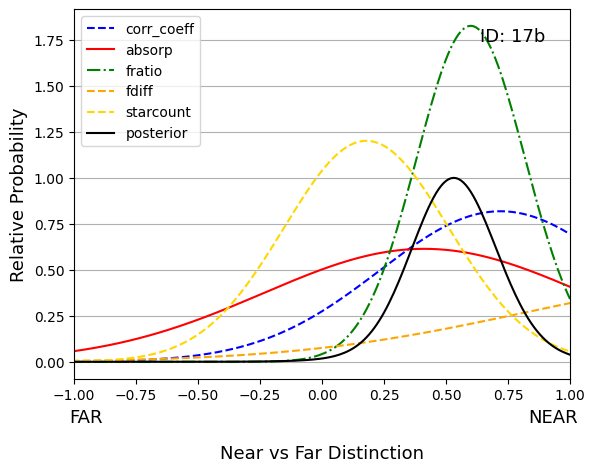

In [552]:
cloudd = '17b'
pdfvec=ppdf(cloudd)
plot_pdf(cloudd,pdfvec)

In [217]:
i_std = 0.10115882466693304 
pri_std = 0.48737371267074825


(i_std**2 * pri_std**2)/(pri_std**2 + i_std**2)

0.009810465506590075

In [310]:
corr_coeff[25]

0.72

In [289]:
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                          p0 = [0.2, 0.26254095,0.000412409531231849])

parameters

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_7270/2705022544.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior,


array([0.2       , 0.26254095, 0.00041241])

In [262]:
print(pdfvec.absorp)
print(pdfvec.fratio)
print(pdfvec.fdiff)
print(max(pdfvec.posterior))

[2.03730466e-217 3.31227922e-217 5.38387479e-217 ... 6.42303629e-196
 4.04877718e-196 2.55155202e-196]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
5.481961324381546


In [263]:
vars(pdfvec)

{'corr_coeff': array([0., 0., 0., ..., 0., 0., 0.]),
 'absorp': array([2.03730466e-217, 3.31227922e-217, 5.38387479e-217, ...,
        6.42303629e-196, 4.04877718e-196, 2.55155202e-196]),
 'fratio': array([0., 0., 0., ..., 0., 0., 0.]),
 'fdiff': array([0., 0., 0., ..., 0., 0., 0.]),
 'starcount': array([0., 0., 0., ..., 0., 0., 0.]),
 'posterior': array([0., 0., 0., ..., 0., 0., 0.])}

In [264]:
parameters, covariance = curve_fit(gaussian, x, pdfvec.posterior)

In [265]:
parameters

array([ 5.48270561,  0.76119899, -0.07276376])

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_20874/3237698950.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_20874/3237698950.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  fratio_norm = integrate.quad(flux_ratio_gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_20874/3237698950.py:31: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested toleran

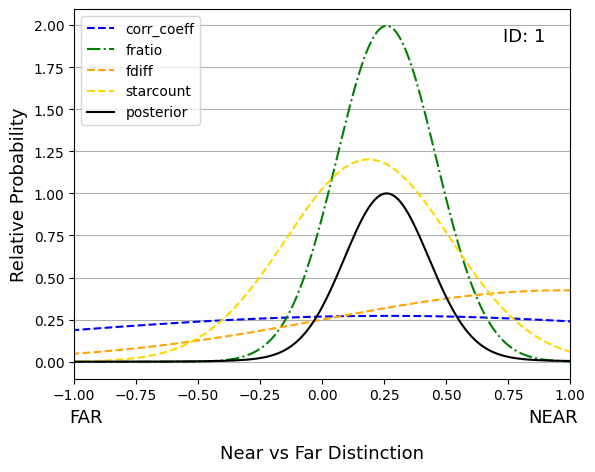

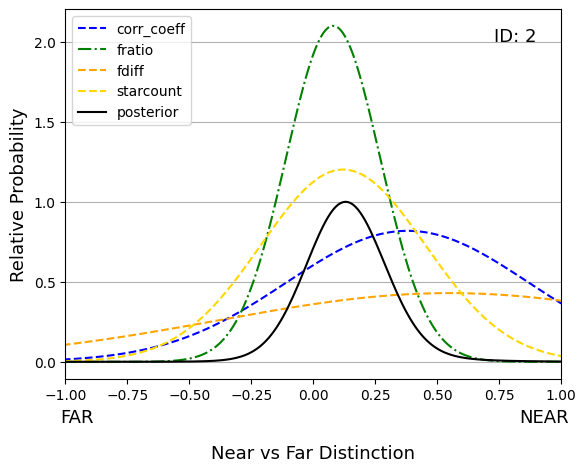

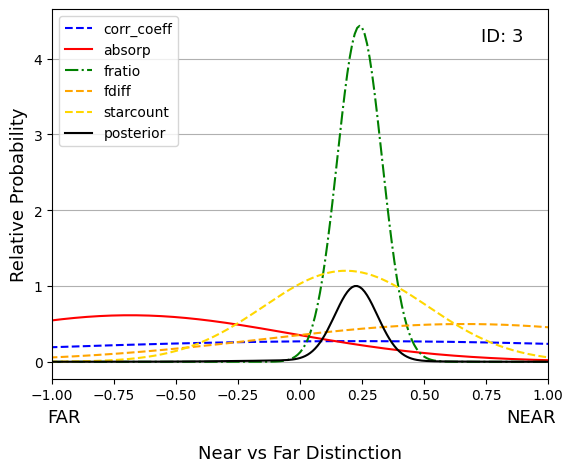

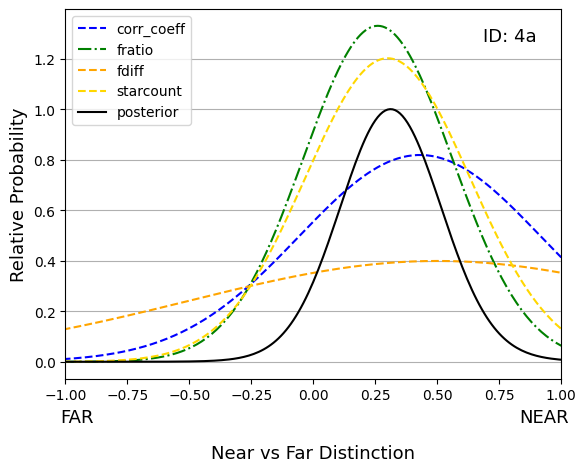

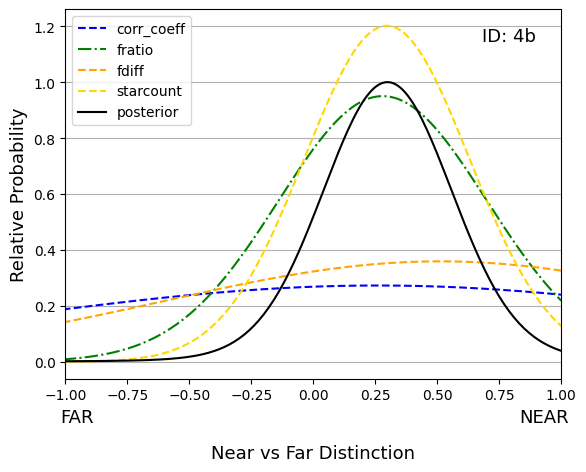

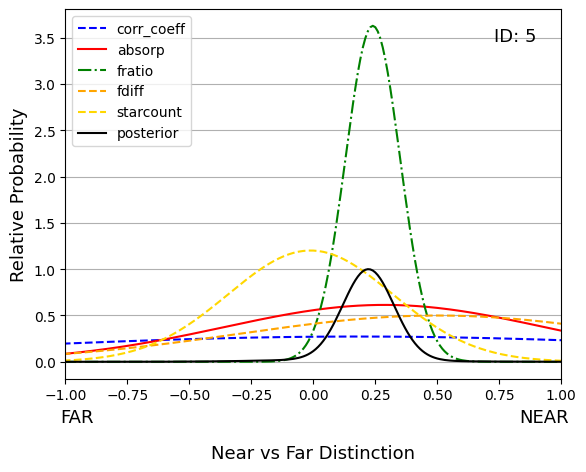

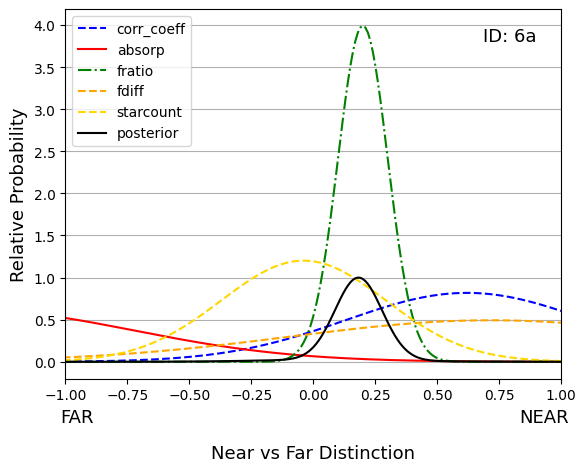

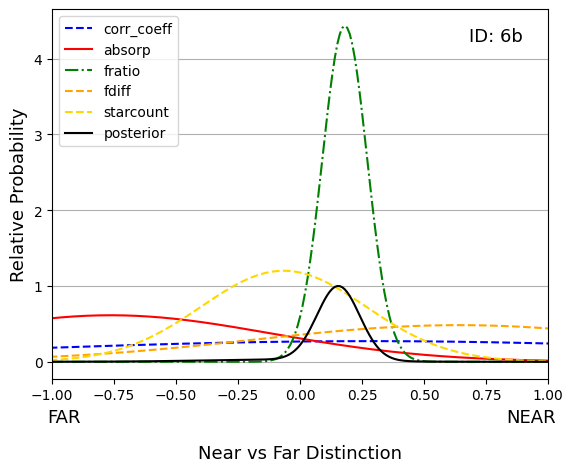

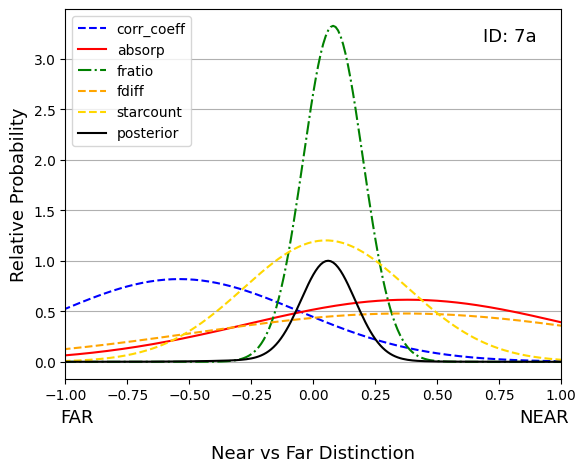

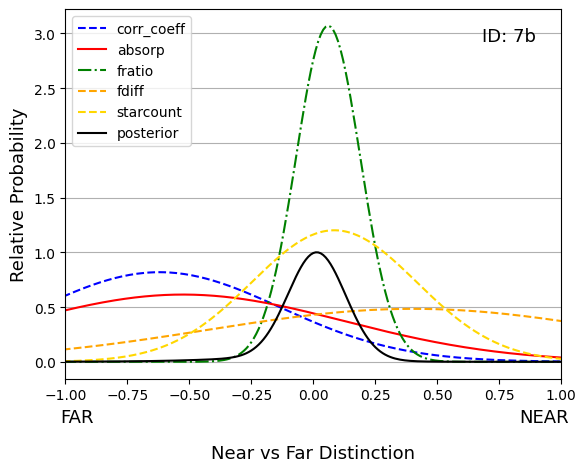

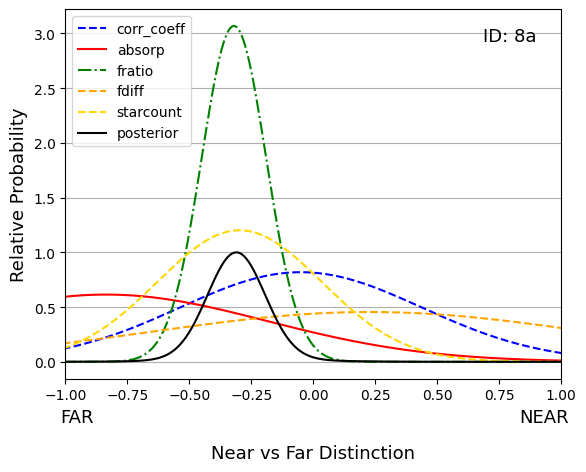

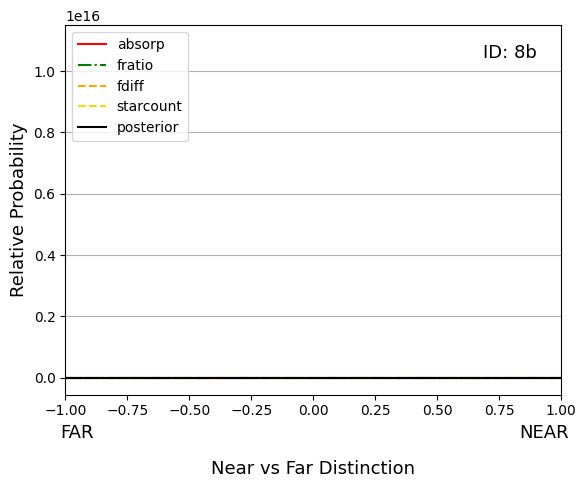

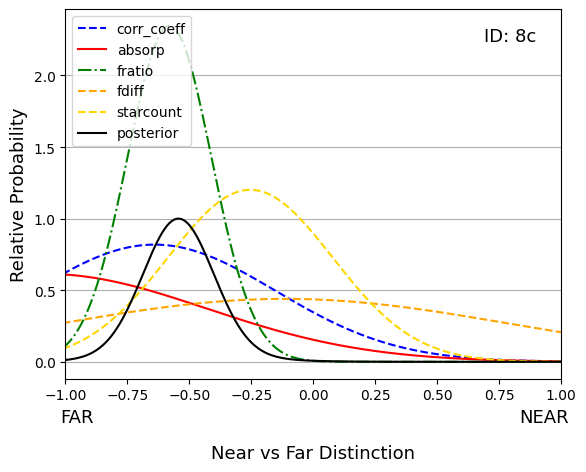

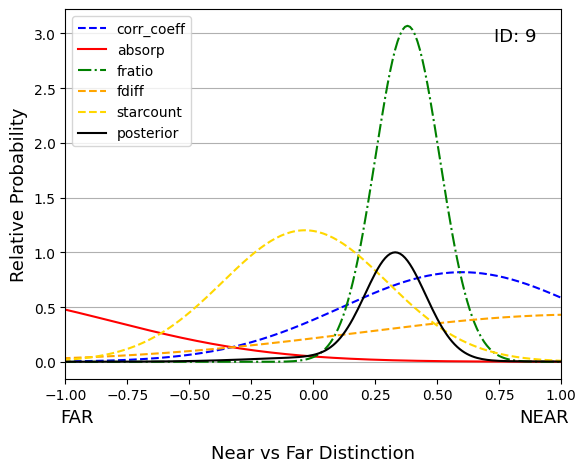

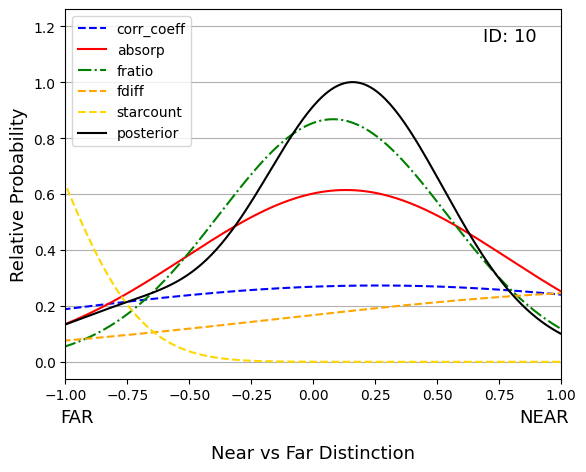

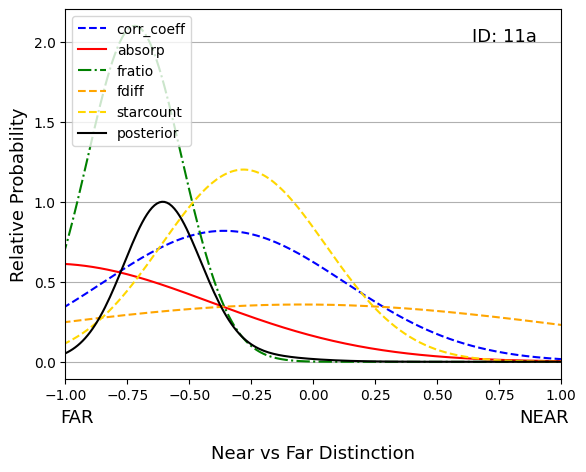

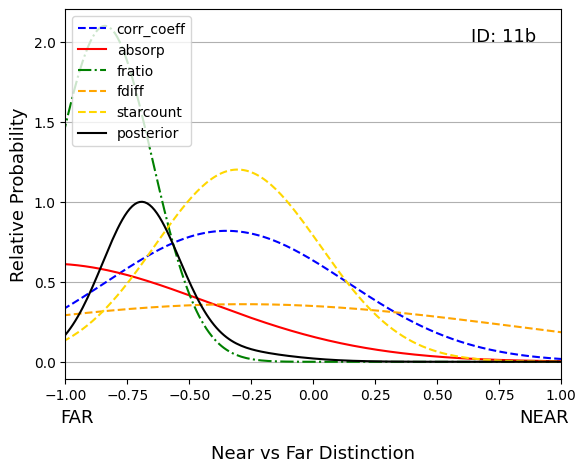

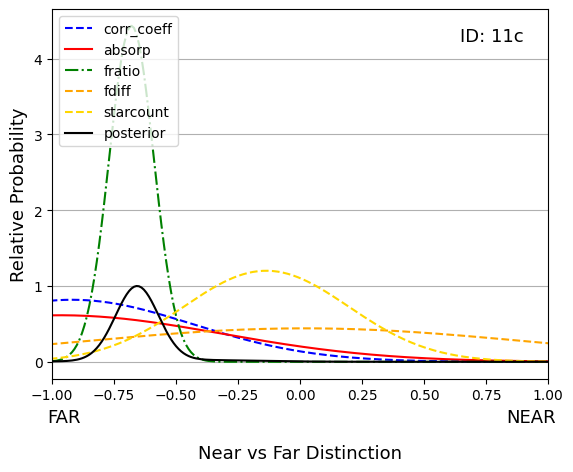

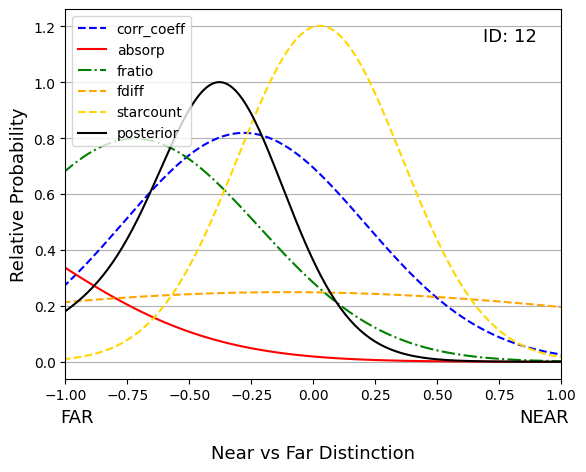

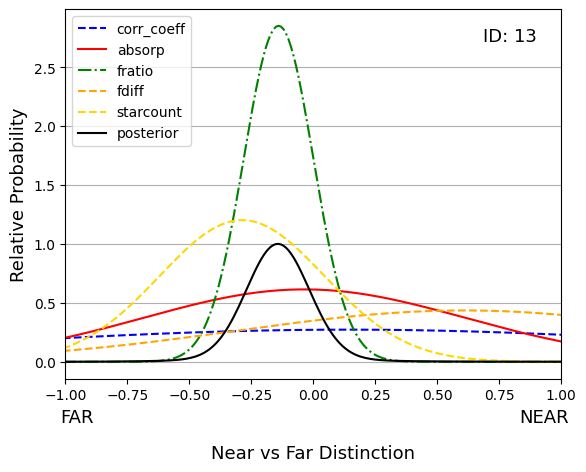

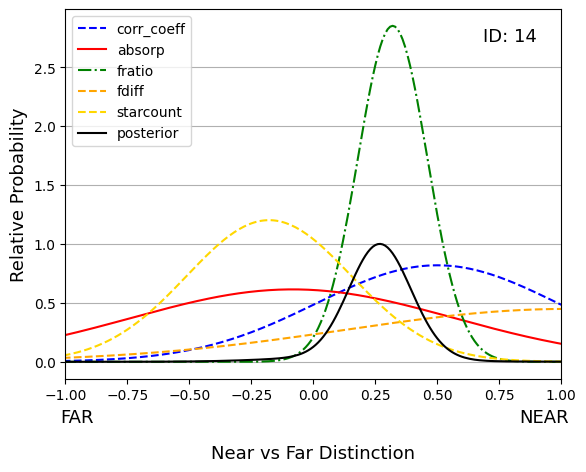

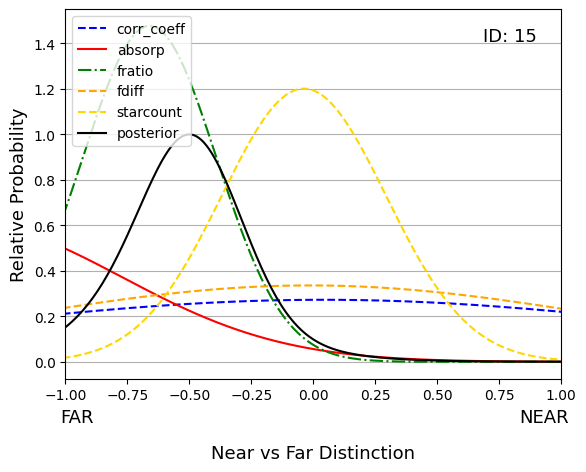

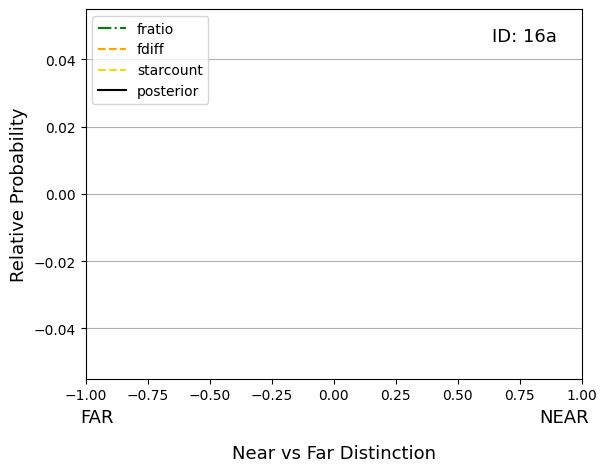

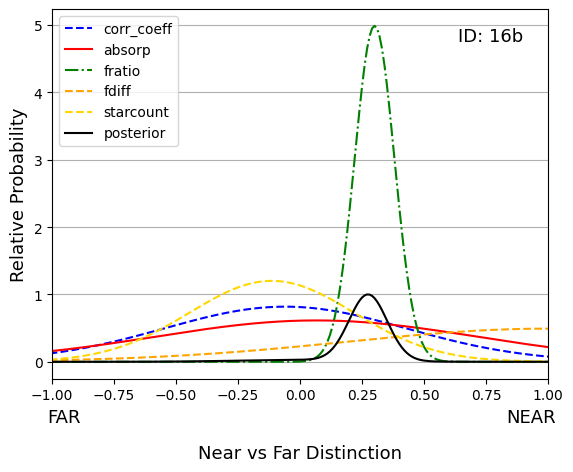

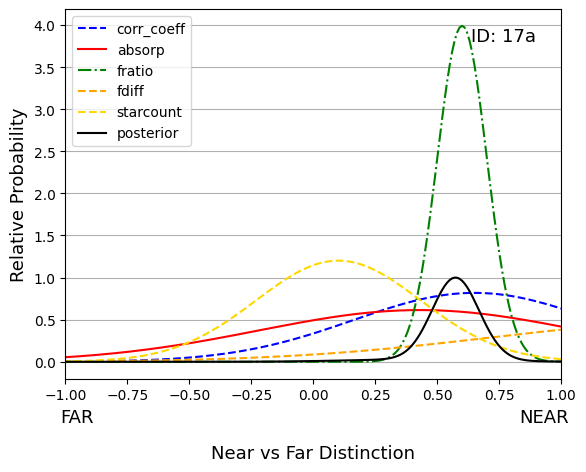

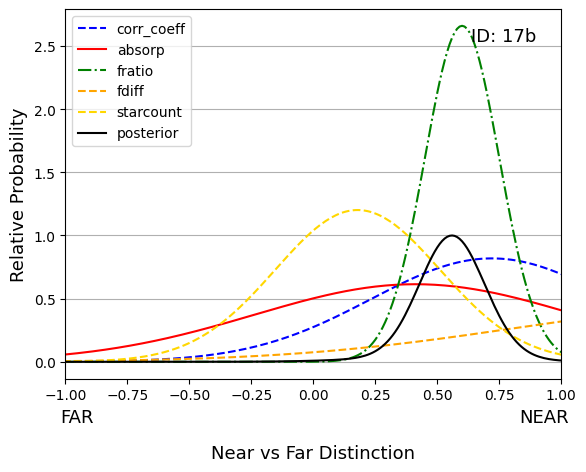

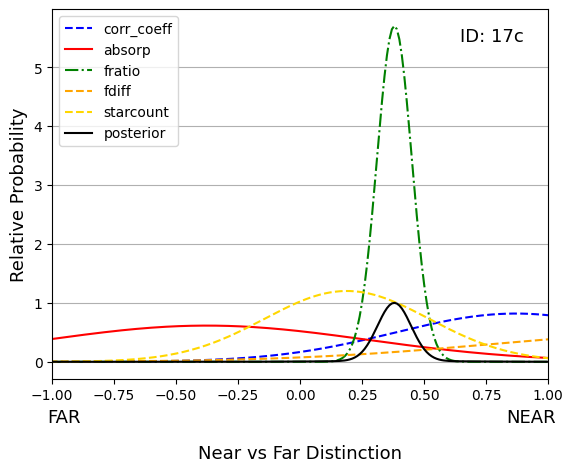

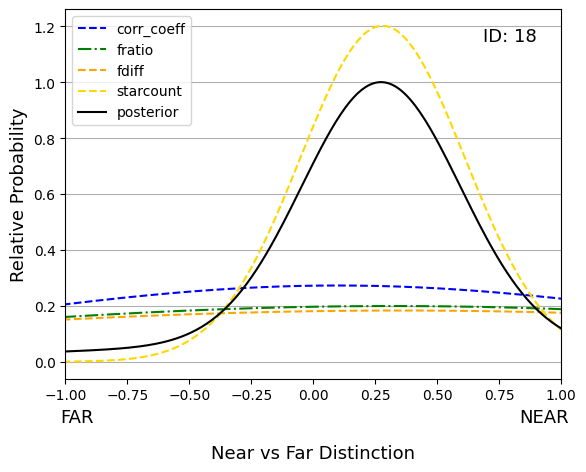

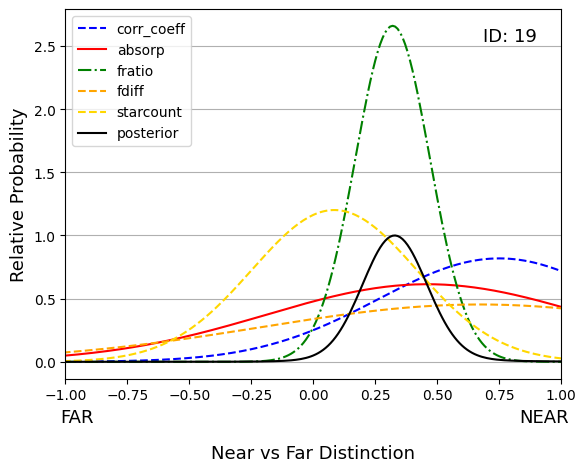

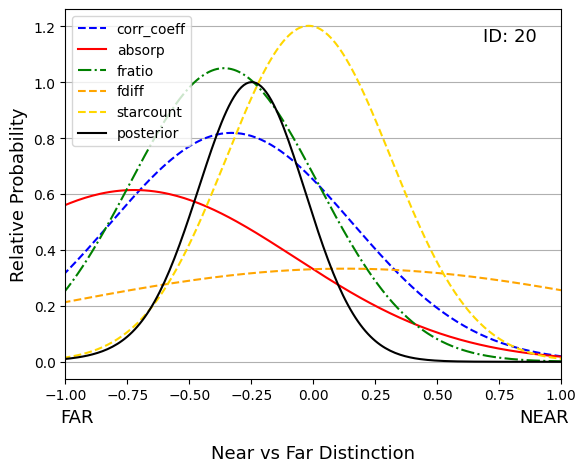

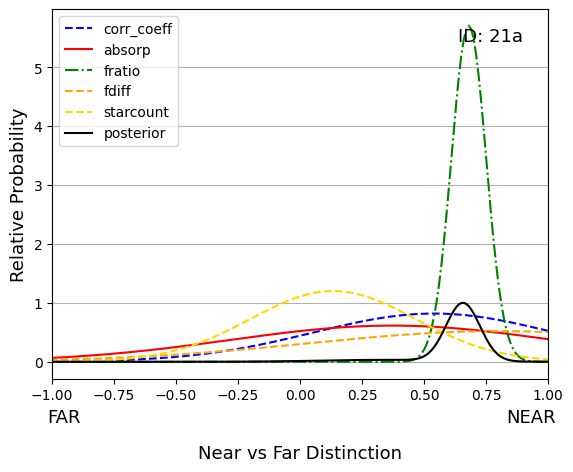

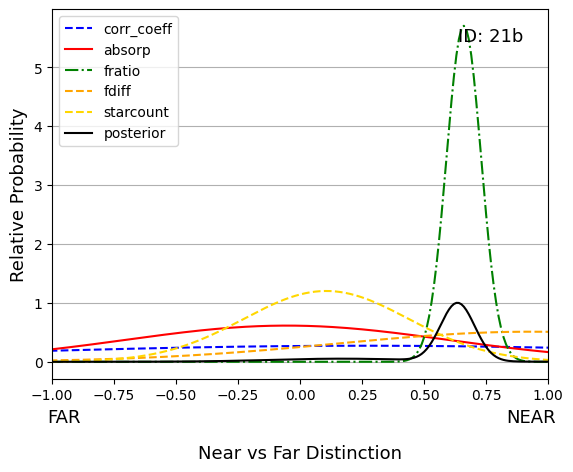

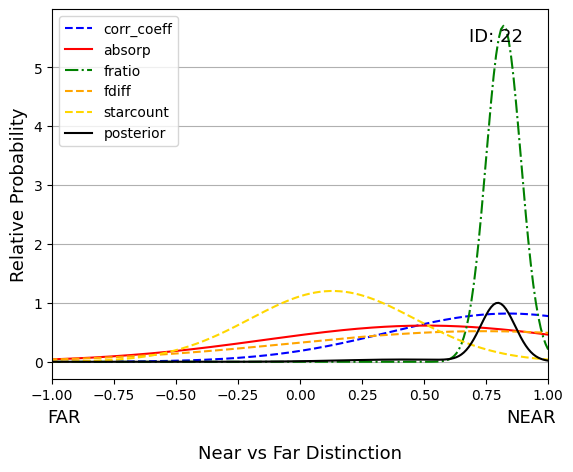

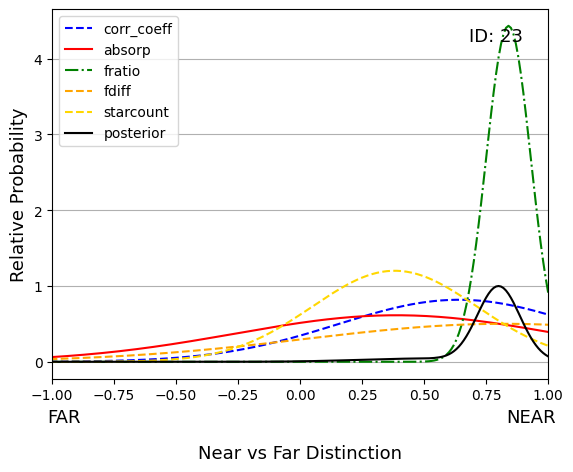

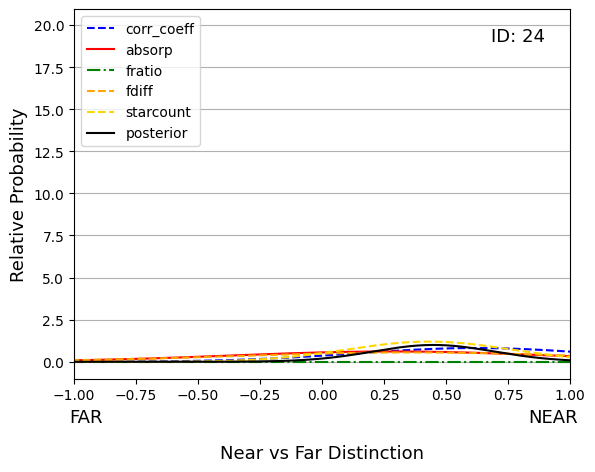

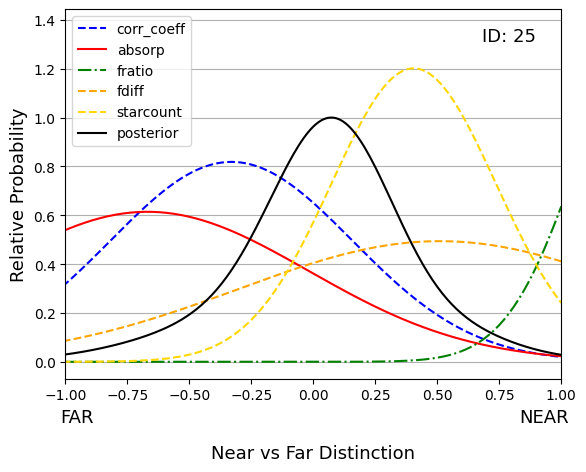

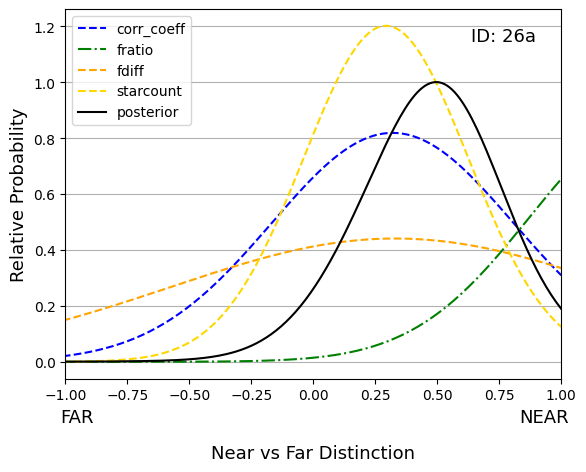

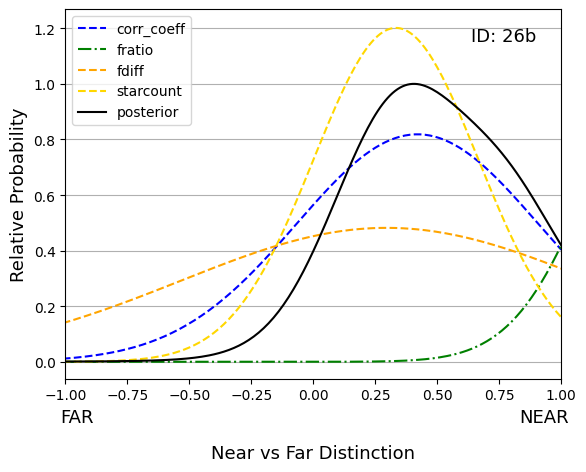

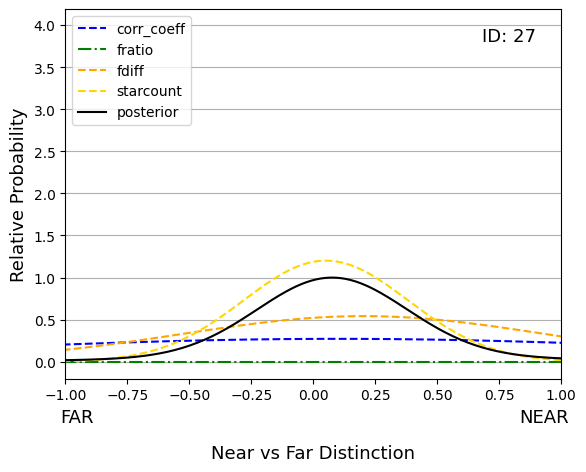

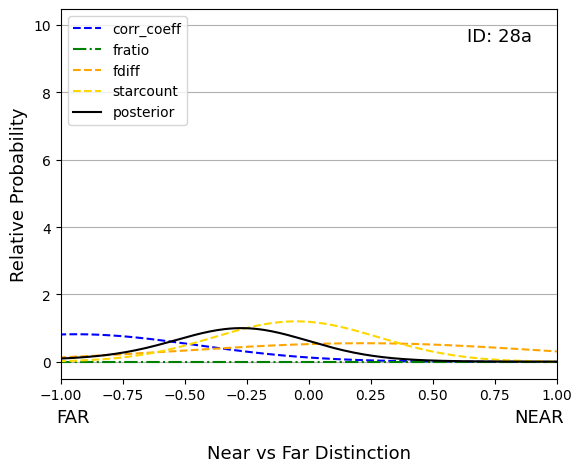

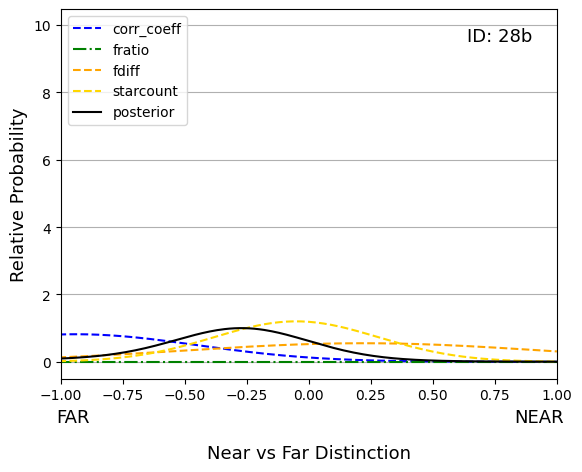

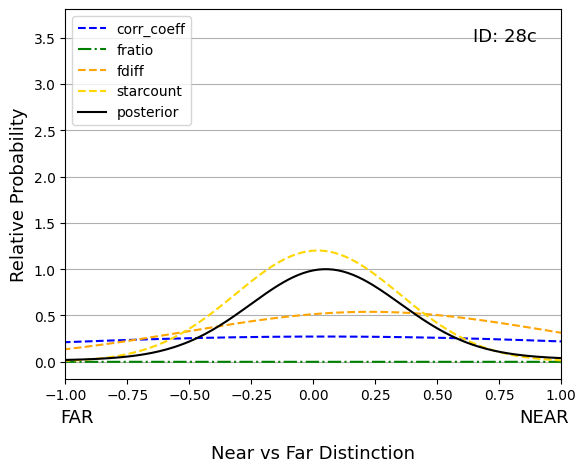

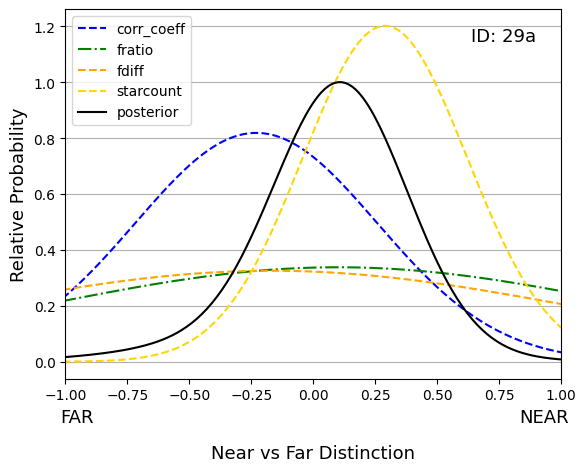

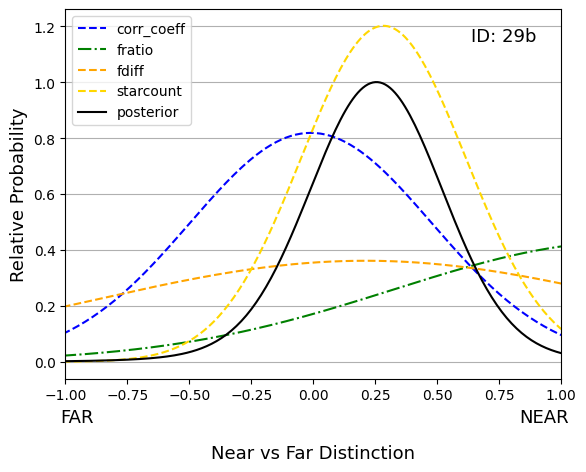

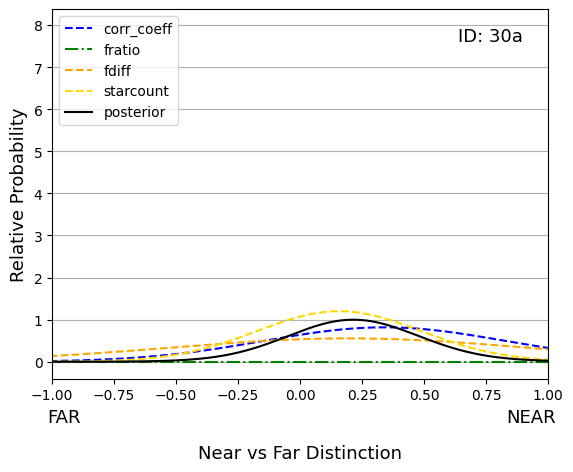

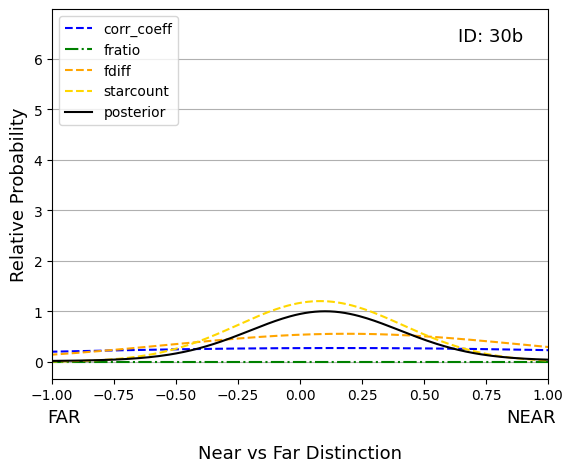

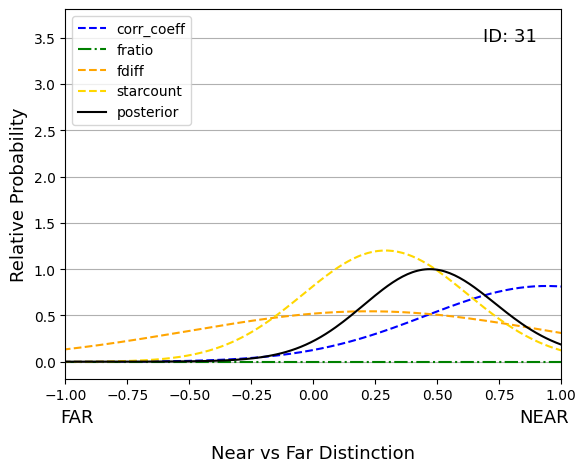

In [450]:
post_tab = Table()
A, mu, sigma, cloudid = [], [], [], []

for i in cat_index:
    cat_id = np.where(cat_index == i)[0][0]
        
    pdfvec=ppdf(i)

    plot_pdf(i, pdfvec)
    if ~np.isnan(pdfvec.posterior).any() == True:
        parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                          p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
        A.append(parameters[0])
        mu.append(parameters[1])
        sigma.append(parameters[2])
        cloudid.append(i)
    else:
        A.append(np.nan)
        mu.append(np.nan)
        sigma.append(np.nan)
        cloudid.append(i)

post_tab['cloud_id'] = cloudid
post_tab['A'] = A
post_tab['mu'] = mu
post_tab['sigma'] = sigma

    
post_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex", overwrite=True)



In [126]:
post_tab[10:]

cloud_id,A,mu,sigma
str3,float64,float64,float64
8a,1.0000400700304766,-0.19979772382544891,0.022595618900485042
8b,1.005013718183623,-0.28226298250758847,0.02262712957999509
8c,1.020501728524716,-0.24507213818411788,0.024459943322048844
9,1.0004175513978473,0.3133705953052106,0.11664925501890981
10,1.0000731652179689,-0.7580840820808394,0.15838626186717256
11a,1.000028367389945,-0.3491463248881686,0.11333681693712205
11b,1.0002041147065794,-0.6473924881657553,0.12906137892400707
11c,1.0013831946142706,0.01834039618918002,0.031564424374888995
12,1.0001548483795257,0.03850407655940352,0.08500761849111048


In [82]:
mu[18]

1.3226841370925617

In [83]:
cat_index[18]

'12'